In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/enron3.csv
/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/enron2.csv
/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/enron1.csv
/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/enron4.csv
/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/enron5.csv
/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/enron6.csv
/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/combined_enron.csv


# Imports
Firstly, all necessary libraries are imported.

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.stats import mode
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
#warnings.filterwarnings('ignore')

# Data Retrieval
We retrieve e-mail data for spam and ham classification with the help of pandas library.

In [3]:
df = pd.read_csv("/kaggle/input/spam-or-ham-a-dataset-for-email-classification/dataset/combined_enron.csv")

# Numerical EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33702 entries, 0 to 33701
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      33702 non-null  object
 1   label_num  33702 non-null  int64 
 2   text       33702 non-null  object
dtypes: int64(1), object(2)
memory usage: 790.0+ KB


We have 33702 e-mail entries. Each e-mail entry has 3 cloumns. "label" column keeps the spam-ham classification. "label_num" column also keeps the spam-ham classification but in integer format as 1 representing spam and 0 representing ham. "text" column keeps the contents of the e-mail.

In [5]:
df.describe()

,label_num
count,33702.000000
mean,0.509080
std,0.499925
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


With the describe method from pandas library, we can observe that almost half of the dataset consists of spam e-mails and the majority of e-mails are spam.

In [6]:
df.head()

,label,label_num,text
0,ham,0,subject fw weather sites this is the list of w...
1,spam,1,subject i cant believe the changma wow wow wow...
2,spam,1,subject 4 color printing special request addit...
3,spam,1,subject nobody can beat us poloponybreakaway i...
4,ham,0,subject energy extravaganza 2 weeks away energ...


First 5 entries in the dataset are shown above as an example.

# Visual EDA

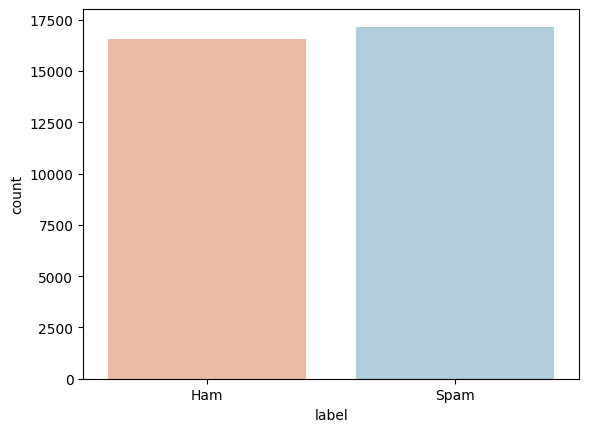

In [7]:
plt.figure()
sns.countplot(x="label", data=df, palette="RdBu")
plt.xticks([0, 1], ["Ham", "Spam"])
plt.show()

With the help of visual EDA, we can conclude the same result with numerical EDA. There are a little more spam e-mails then ham e-mails. Also, there is no corrupted or unexpected data.

# Data Preprocessing

In [8]:
for index, row in df.iterrows():
    if row["label"] == "spam" and row["label_num"] != 1:
        row["label_num"] = 1
        print("Changed")
    elif row["label"] == "ham" and row["label_num"] != 0:
        row["label_num"] = 0
        print("Changed")

Just to be sure with the number labeling all rows are checked in a loop and changed if they are wrong for any reason. label_num data seems to be intact since "Changed" string hasn't been printed even once. Now we can safely remove the label column.

In [9]:
df = df.drop("label", axis=1)
df.head()

,label_num,text
0,0,subject fw weather sites this is the list of w...
1,1,subject i cant believe the changma wow wow wow...
2,1,subject 4 color printing special request addit...
3,1,subject nobody can beat us poloponybreakaway i...
4,0,subject energy extravaganza 2 weeks away energ...


# Vectorizer
We need to vectorize the text data to be able to use it in our machine learning computations.

In [10]:
vectorizer = TfidfVectorizer(stop_words="english")
vec = vectorizer.fit_transform(df["text"])
vec.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Train-Test Split
30% of data is split as test data. We won't need labels while model fitting but splitting the data still helps.

In [11]:
y = df["label_num"]
X = vec
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

# K-Means Clustering
We don't need to observe inertia values as we only have 2 labels. We can simply select the cluster number as 2. We can use first 23600 data points as training points to so that almost 70% of the data is used for this reason.

In [13]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train_svd)
y_pred = kmeans.predict(X_test_svd)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Below is the implementation of align_clusters method. It determines which cluster is which according to majority vote. Then, this method is invoked after its definition.

In [14]:
def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask])[0]
    return labels
y_pred_aligned = align_clusters(y_test, y_pred)

# Results

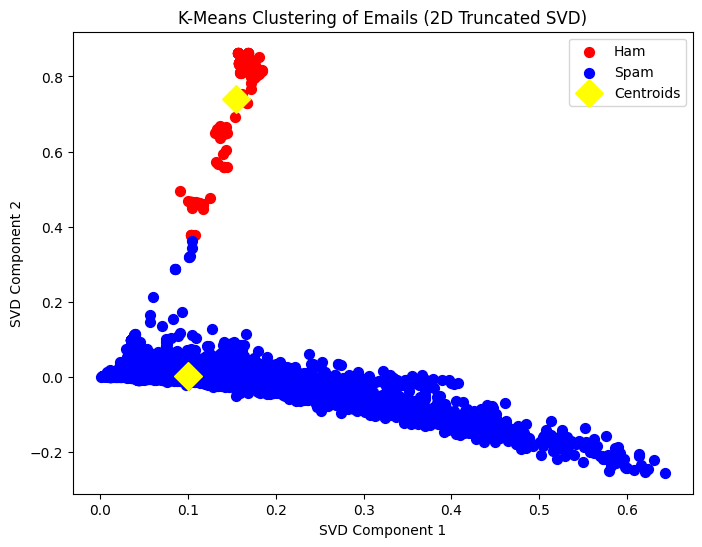

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test_svd[y_pred_aligned == 0, 0], X_test_svd[y_pred_aligned == 0, 1], 
            s=50, c='red', label='Ham')
plt.scatter(X_test_svd[y_pred_aligned == 1, 0], X_test_svd[y_pred_aligned == 1, 1], 
            s=50, c='blue', label='Spam')
centroids_2d = kmeans.cluster_centers_
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='D', s=200, c='yellow', label='Centroids')
plt.title('K-Means Clustering of Emails (2D Truncated SVD)')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend()
plt.show()

Clusters can be seen with their centroids on a 2D plane above. We see clusters aren't intertwined at any area. This is the result of TfidfVectorizer.

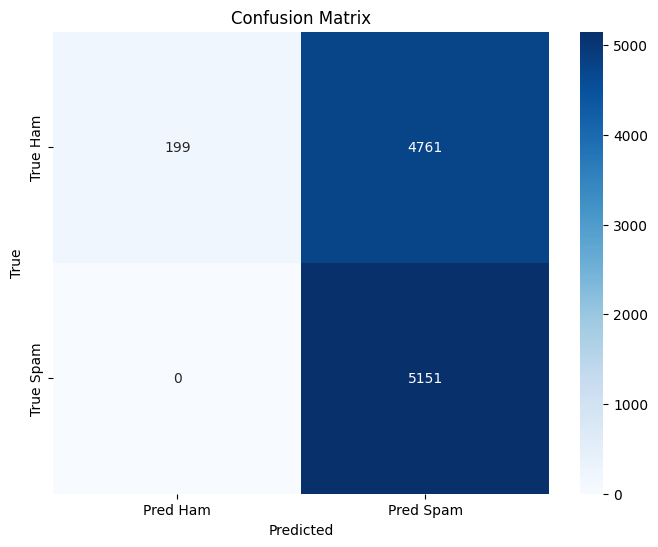

,precision,recall,f1-score,support
0,1.000000,0.040121,0.077147,4960.000000
1,0.519673,1.000000,0.683928,5151.000000
accuracy,0.529127,0.529127,0.529127,0.529127
macro avg,0.759837,0.520060,0.380537,10111.000000
weighted avg,0.755300,0.529127,0.386268,10111.000000


In [16]:
cm = confusion_matrix(y_test, y_pred_aligned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Ham', 'Pred Spam'], yticklabels=['True Ham', 'True Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
cr = classification_report(y_test, y_pred_aligned, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cr_df

K-Means Clustering model predicted the labels with 53% accuracy. Confusion matrix and classification report are shown above.

# Conclusion
We can conclude that K-Means Clustering algorithm isn't a good model for this dataset. Its accuracy is extremely low and it labeled almost every e-mail as spam. Only good thing it achieved was labeling every true spam e-mails as spam e-mails. This result might have multiple reasons. Firstly, none of our data had continuous variables. K-Means Clustering seems to be working better with continuous data. Secondly, we created too many dimensions at the same time from our data and then reduce them to 2 too fast. We might have lost some knowledge in the process. Thirdly, relation between our data might be low. Therefore, seeing a trend among them could be hard. Overall, K-Means Clustering algorithm doesn't seem to be an appropriate model at least for this data if not for any e-mail spam/ham classifiers. It is suggested to do more data preprocessing to reach to a better conclusion.